# Tutorial

In this tutorial, I am going to show how to read and visualize the raw data and preprocessed data uing mainly python and matplotlib, so that you have a better understanding of the data and directory structure.

I am assuming you have installed all the dependencies and downloaded the data. Please refer to the README.md for detailed installation instructions and where to put the downloaded data. We assume here you have downloaded dataset2 and 3 using the public available link https://github.com/uci-cbcl/UaNet#Data. If you have downloaded the test set of dataset 1, put them into the same folder (data/raw and data/preprocessed folders). 

In data, we have two folders: one is raw and one is preprocessed. In raw, those are the images and annotations from the doctors, extracted from the original dicom by us. In preprocessed, the original image were preprocessed in order for efficient training. There are two types of preprocessing: for dataset1 and dataset2, we used utils/preprocess.py to process all the images, because those are the data and annotations we generated; for dataset3 (which is the MICCAI15 challenge data), we used the crop data from https://github.com/wentaozhu/AnatomyNet-for-anatomical-segmentation. If you just want to see the model training, then you only need to use preprocessed images. Feel free to use other preprocessing methods, if you want to use your own preprocessing.

Let's first import some helper functions and initialize some global variables.

In [2]:
from config import config
import numpy as np
import os
import nrrd
from utils.util import get_contours_from_masks, merge_contours, merge_masks, annotation2masks, normalize
from utils.visualize import show3D_comparison, show3Dimg, show3Dimg2, show_image_and_mask, draw_gt, draw_pred
import matplotlib.pyplot as plt
# %matplotlib inline
# You can change the size of the plotted images, in order to fit your screen
plt.rcParams['figure.figsize'] = (16, 12)

raw_data_dir = config['data_dir']
preprocessed_data_dir = config['preprocessed_data_dir']

Then, Let's load the raw data first and take a look at the original CT image

In [3]:
# Load all the names of the CT scans
pids = np.genfromtxt('split/release_dataset2_train.csv', dtype=str, delimiter='\n')

# Let's select the first CT scan
i = 1
pid = pids[i]
print('patient/CT scan Id: ', pid)

# Load the CT image
image, header = nrrd.read(os.path.join(raw_data_dir, pid, 'img.nrrd'))
# Because the raw image are stored as [x, y, z], we need to swap axis to [z, y, x]
image = np.swapaxes(image, 0, -1)
# We will need to normalize the image to [0, 1], so our visualization tools can work properly
# normalize function will normalize the image values to [-1, 1], so we need to (+ 1) / 2
image = (normalize(image) + 1) / 2.

# Load available masks for each OAR in this patient
mask = {}
for i, roi in enumerate(config['roi_names']):
    if os.path.isfile(os.path.join(raw_data_dir, pid, 'structures', '%s.nrrd' % (roi))):
        m, _ = nrrd.read(os.path.join(os.path.join(raw_data_dir, pid, 'structures', '%s.nrrd' % (roi))))
        m = np.swapaxes(m, 0, -1)
        mask[roi] = m
                         
# The mask array is [# OARs, D, H, W], where D, H, W is as the same shape as image
all_masks = annotation2masks(mask).astype(np.float32)

show3Dimg(image)

patient/CT scan Id:  PA002


interactive(children=(IntSlider(value=0, description='k', max=159), Output()), _dom_classes=('widget-interact'…

We can overlay the mask onto the image. This is a very coarse level visualization. But it should be sufficient to show the data and mask, and how they are aligned.

A more advanced visualization (like the ones showed in the paper), would save each CT slice to png. (Jupyter notebook just goes so slow in loading them dynamically)

In [4]:
gt_img = draw_gt(image, merge_masks(all_masks.astype(np.uint8)))
show_image_and_mask(gt_img)

interactive(children=(IntSlider(value=0, description='k', max=159), Output()), _dom_classes=('widget-interact'…

Then, let's take a look at the preprocessed data

In [5]:
# During preprocess script
# The data has been already swaped to [z, y, x] format, so we do not need to swap them again here
image, _ = nrrd.read(os.path.join(preprocessed_data_dir, '%s_clean.nrrd' % (pid)))
# image = (normalize(image.copy()) + 1) / 2

mask = {}
for i, roi in enumerate(config['roi_names']):
    if os.path.isfile(os.path.join(preprocessed_data_dir, '%s_%s.nrrd' % (pid, roi))):
        m, _ = nrrd.read(os.path.join(preprocessed_data_dir, '%s_%s.nrrd' % (pid, roi)))
        mask[roi] = m

all_masks = annotation2masks(mask).astype(np.float32)

show3Dimg(image)

interactive(children=(IntSlider(value=0, description='k', max=159), Output()), _dom_classes=('widget-interact'…

This time, let us try using another overlay.

IntSlider(value=0, continuous_update=False, description='z', max=159)

IntSlider(value=0, continuous_update=False, description='level', max=1000, min=-1024)

IntSlider(value=1000, continuous_update=False, description='width', max=2000, min=-1024)

Checkbox(value=True, description='show mask')

<IPython.core.display.Javascript object>


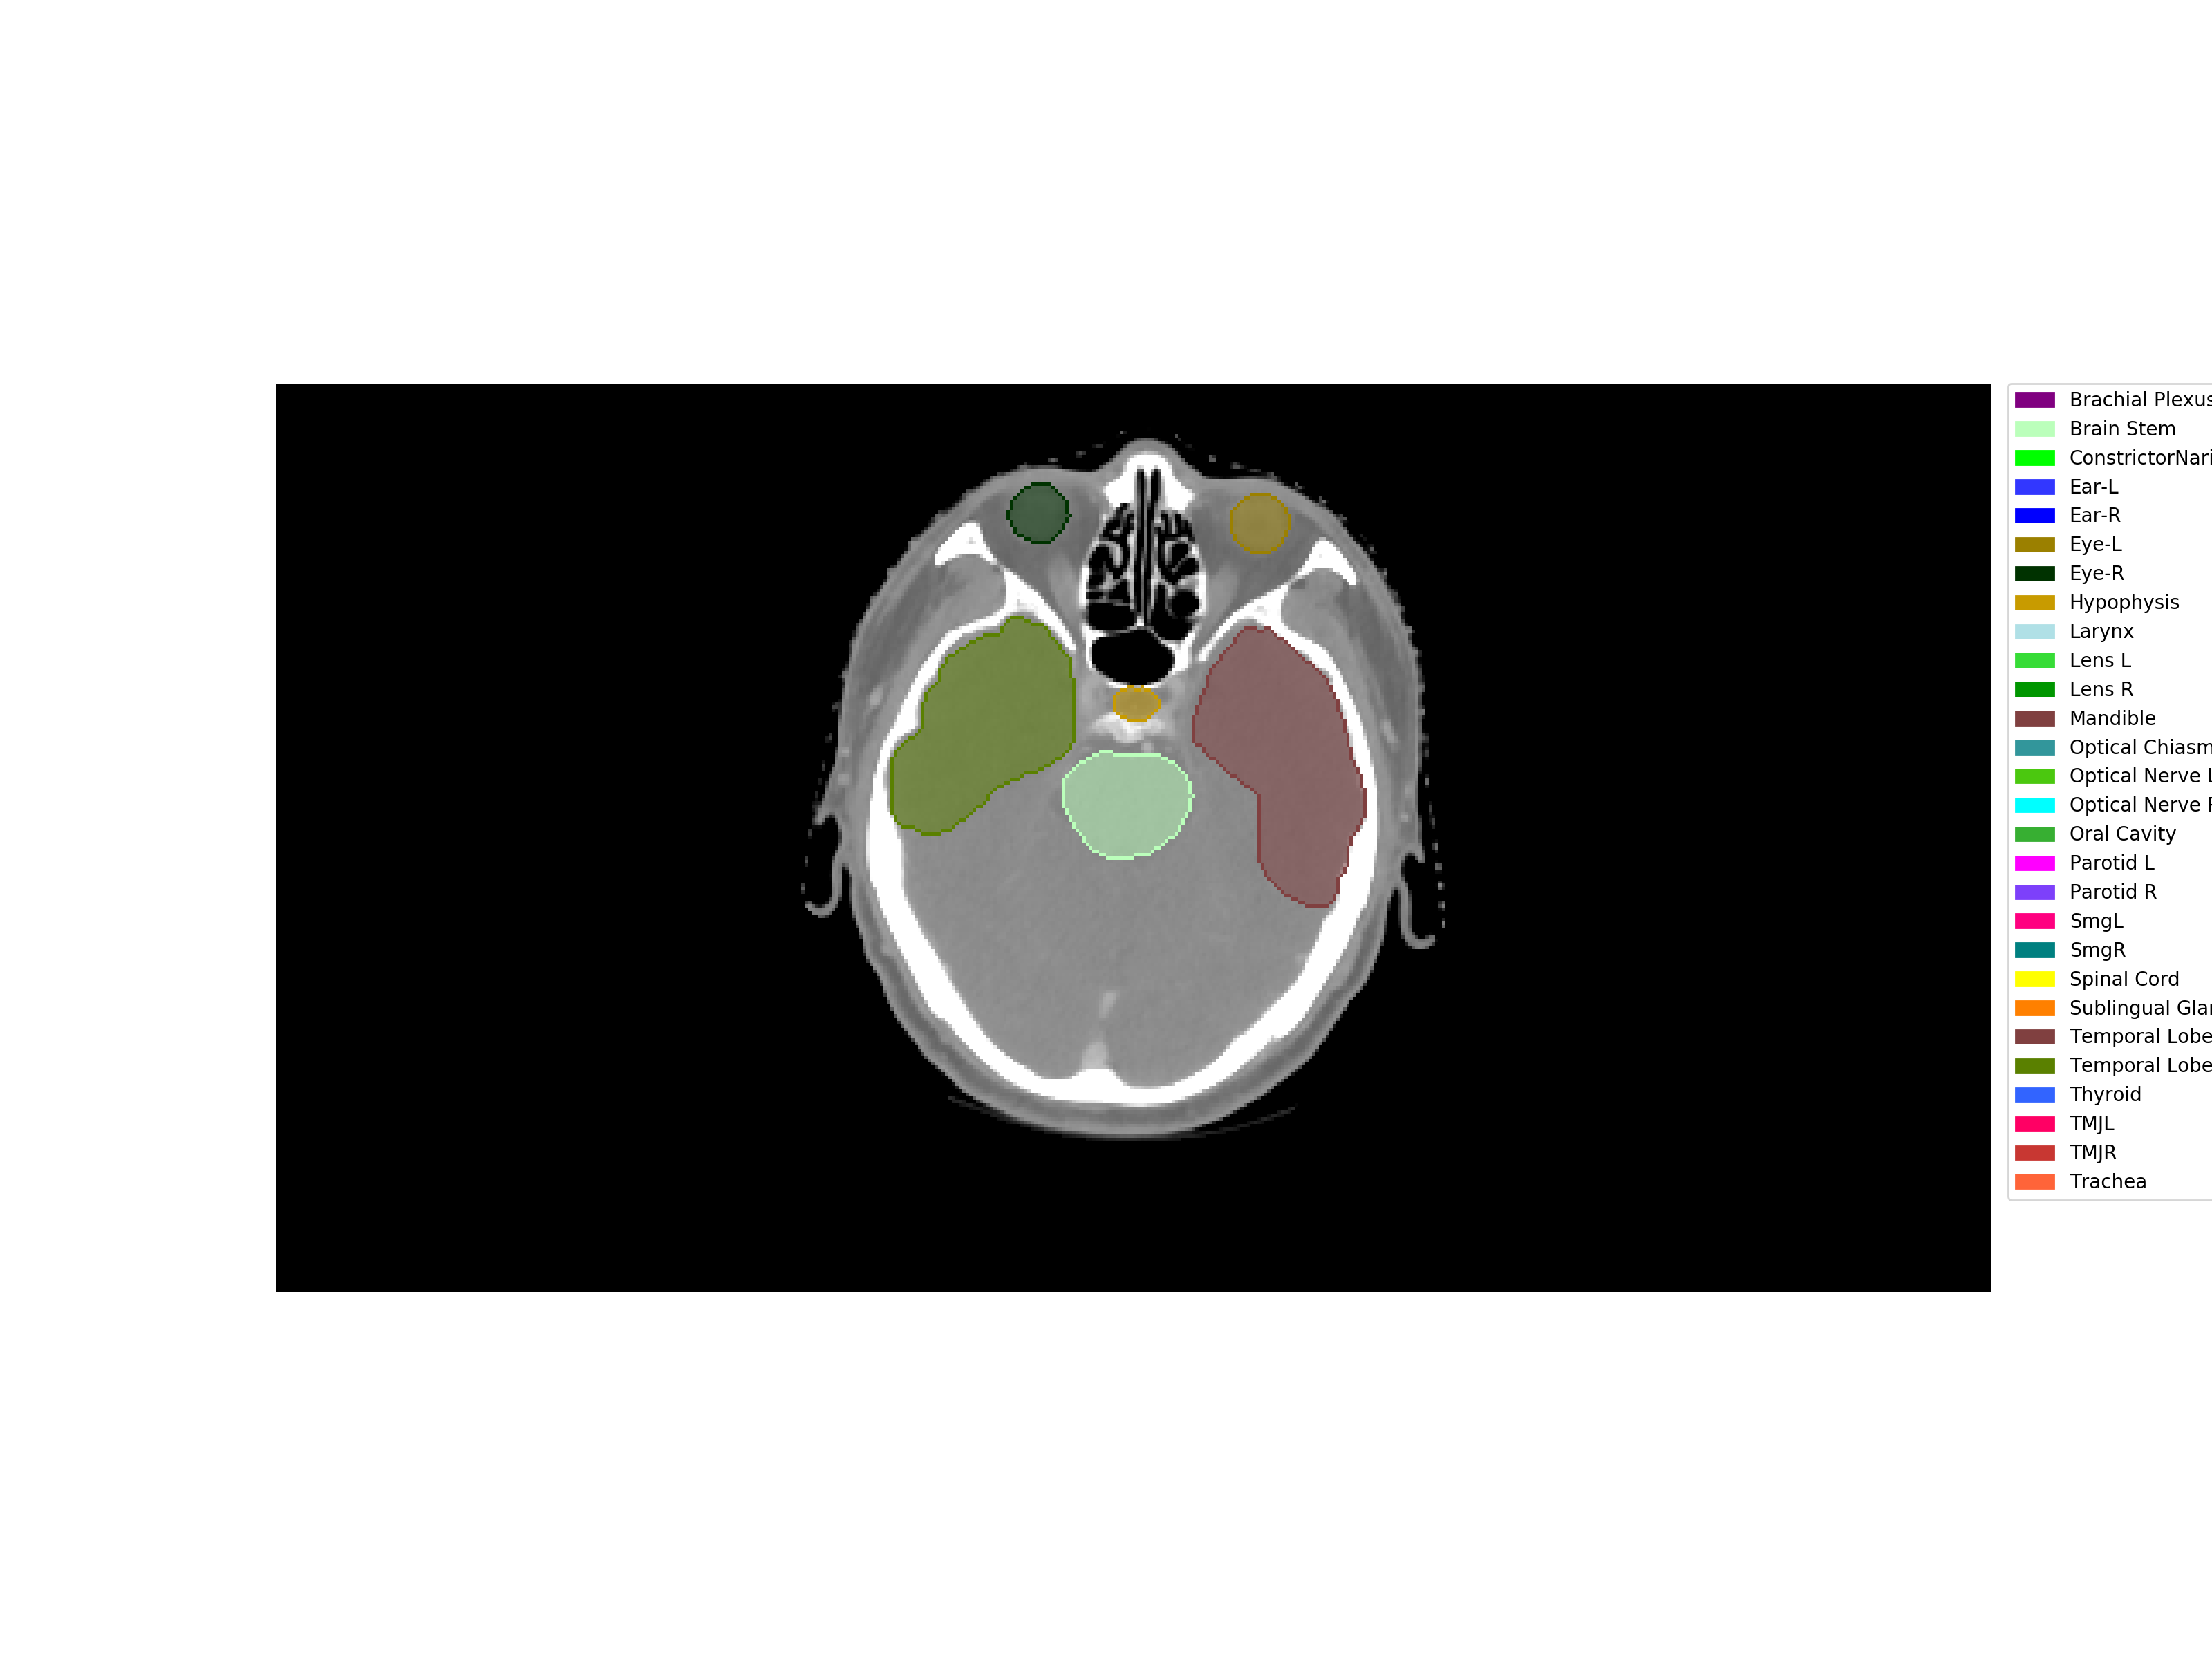

In [6]:
%matplotlib notebook

# This will also have sliders for window width and window level, just like in other softwares
# Alghouth it is slow and sometime freezes. There should be ways optimizing this
#
# By default, the first is the image, all the others would be masks. 
# The second mask (which is contour) would be drawn using alpha value 1.0
# while the first using 0.5. So that we could see the contour and CT image as well.
show3Dimg2(image, merge_masks(all_masks), merge_contours(get_contours_from_masks(all_masks)))